In [ ]:
!pip install -qU  malariagen_data scikit-allel
!pip install -q petl 

In [ ]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import functools
#import dask 
#from dask.diagnostics.progress import ProgressBar
#dask.config.set(**{'array.slicing.split_large_chunks': True})
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
#import matplotlib_venn as venn
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
from tqdm.dask import TqdmCallback
from tqdm.auto import tqdm
import petl as ptl
import scipy
import scipy.cluster
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import _convert_to_double
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy
import bisect

In [ ]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir 
results_dir = "drive/MyDrive/Insecticide_resistance/vgsc_results/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [ ]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)

## Let's check the the sample set
sets = ["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")

Load sample metadata:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
## Acces to the haplotypes 
df_hap = ag3.haplotypes(region="2L", analysis='gamb_colu_arab', sample_sets=sets)
# samples phase 
samples_phased = df_hap['sample_id'].values
df_samples_phased = df_samples.set_index("sample_id").loc[samples_phased].reset_index()

# Let's define the genome region where to locate the SNP
hap_variant = df_hap['variant_position'].data
hap_pos = allel.SortedIndex(hap_variant)

#######
loc_region = hap_pos.locate_range(2358158,2431617)
#loc_region
pos_loc = hap_pos[loc_region]

## Cohort 
#loc_samples = df_samples_phased.query(cohort).index.values
vgsc_haps = df_hap.sel(variants = loc_region)

In [ ]:
# define dictionary of pop colors
pop_colours = {
 'Pala coluzzii' : "sienna",
 'Pala gambiae' : "tomato",
 'Pala arabiensis' : "maroon",
 'Bana coluzzii' : "orange",
 'Bana gambiae' : "skyblue",
 'Souroukoudinga gambiae' : "cadetblue",
 'Souroukoudinga coluzzii' : "slateblue",
 'Monomtenga gambiae' : "hotpink"
}

In [ ]:
meta = df_samples_phased
meta['location'] = meta['location'].str.replace('_.*', '', regex=True)
meta['aim_species'] = meta['aim_species'].str.replace('intermediate_gambiae_coluzzii', 'intermediate')

loca = []
loca_i = ['Pala', 'Souroukoudinga', 'Monomtenga']
for loc in meta.location:
  if loc in loca_i:
    loca.append(loc)
  else:
    loca.append(loc.split(' ')[0])
meta.insert(4, 'location_1', loca)
#bf_meta = meta[loc_samples]

In [ ]:
# Now make the metadata match by excluding those same samples. 

# Create a column that adds the species name to the location name, for clearer labelling of plots
location_species = {'Bana' : 'coluzzii',
                    'Pala' : 'coluzzii',
                    'Pala' : 'arabiensis',
                    'Bana' : 'gambiae',
                    'Pala' : 'gambiae',
                    'Souroukoudinga' : 'gambiae',
                    'Souroukoudinga' : 'coluzzii',
                    'Monomtenga' : 'gambiae'}
meta['population'] = [meta.location_1.iloc[i] + ' ' + location_species[meta.location_1.iloc[i]] for i in range(len(meta))]

# Get haplotype-level metadata
hap_meta = pd.DataFrame(np.repeat(meta.values, 2, axis = 0))
hap_meta.columns = meta.columns
hap_meta.index = [hap_meta.sample_id[i] + ['a', 'b'][i%2] for i in range(len(hap_meta))]
hap_meta

,sample_id,partner_sample_id,contributor,country,location_1,location,year,month,latitude,longitude,...,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter,loc_sp,population
AB0085-Cxa,AB0085-Cx,BF2-4,Austin Burt,Burkina Faso,Pala,Pala,2012,7,11.151,-4.235,...,Houet,gambiae,BF-09_gamb_2012,BF-09_gamb_2012_07,BF-09_gamb_2012_Q3,BF-09_Houet_gamb_2012,BF-09_Houet_gamb_2012_07,BF-09_Houet_gamb_2012_Q3,Pala gambiae,Pala gambiae
AB0085-Cxb,AB0085-Cx,BF2-4,Austin Burt,Burkina Faso,Pala,Pala,2012,7,11.151,-4.235,...,Houet,gambiae,BF-09_gamb_2012,BF-09_gamb_2012_07,BF-09_gamb_2012_Q3,BF-09_Houet_gamb_2012,BF-09_Houet_gamb_2012_07,BF-09_Houet_gamb_2012_Q3,Pala gambiae,Pala gambiae
AB0086-Cxa,AB0086-Cx,BF2-6,Austin Burt,Burkina Faso,Pala,Pala,2012,7,11.151,-4.235,...,Houet,gambiae,BF-09_gamb_2012,BF-09_gamb_2012_07,BF-09_gamb_2012_Q3,BF-09_Houet_gamb_2012,BF-09_Houet_gamb_2012_07,BF-09_Houet_gamb_2012_Q3,Pala gambiae,Pala gambiae
AB0086-Cxb,AB0086-Cx,BF2-6,Austin Burt,Burkina Faso,Pala,Pala,2012,7,11.151,-4.235,...,Houet,gambiae,BF-09_gamb_2012,BF-09_gamb_2012_07,BF-09_gamb_2012_Q3,BF-09_Houet_gamb_2012,BF-09_Houet_gamb_2012_07,BF-09_Houet_gamb_2012_Q3,Pala gambiae,Pala gambiae
AB0087-Ca,AB0087-C,BF3-3,Austin Burt,Burkina Faso,Bana,Bana Village,2012,7,11.233,-4.472,...,Houet,coluzzii,BF-09_colu_2012,BF-09_colu_2012_07,BF-09_colu_2012_Q3,BF-09_Houet_colu_2012,BF-09_Houet_colu_2012_07,BF-09_Houet_colu_2012_Q3,Bana gambiae,Bana gambiae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AB0316-Cb,AB0316-C,6779,Nora Besansky,Burkina Faso,Monomtenga,Monomtenga,2004,8,12.06,-1.17,...,Bazega,gambiae,BF-07_gamb_2004,BF-07_gamb_2004_08,BF-07_gamb_2004_Q3,BF-07_Bazega_gamb_2004,BF-07_Bazega_gamb_2004_08,BF-07_Bazega_gamb_2004_Q3,Monomtenga gambiae,Monomtenga gambiae
AB0318-Ca,AB0318-C,5072,Nora Besansky,Burkina Faso,Monomtenga,Monomtenga,2004,7,12.06,-1.17,...,Bazega,gambiae,BF-07_gamb_2004,BF-07_gamb_2004_07,BF-07_gamb_2004_Q3,BF-07_Bazega_gamb_2004,BF-07_Bazega_gamb_2004_07,BF-07_Bazega_gamb_2004_Q3,Monomtenga gambiae,Monomtenga gambiae
AB0318-Cb,AB0318-C,5072,Nora Besansky,Burkina Faso,Monomtenga,Monomtenga,2004,7,12.06,-1.17,...,Bazega,gambiae,BF-07_gamb_2004,BF-07_gamb_2004_07,BF-07_gamb_2004_Q3,BF-07_Bazega_gamb_2004,BF-07_Bazega_gamb_2004_07,BF-07_Bazega_gamb_2004_Q3,Monomtenga gambiae,Monomtenga gambiae
AB0325-Ca,AB0325-C,1403,Nora Besansky,Burkina Faso,Monomtenga,Monomtenga,2004,6,12.06,-1.17,...,Bazega,gambiae,BF-07_gamb_2004,BF-07_gamb_2004_06,BF-07_gamb_2004_Q2,BF-07_Bazega_gamb_2004,BF-07_Bazega_gamb_2004_06,BF-07_Bazega_gamb_2004_Q2,Monomtenga gambiae,Monomtenga gambiae


In [ ]:
meta.population.unique()

array(['Pala gambiae', 'Bana gambiae', 'Souroukoudinga coluzzii',
       'Monomtenga gambiae'], dtype=object)

In [ ]:
gt_cohort = allel.GenotypeDaskArray(vgsc_haps['call_genotype'].data)
gt_cohort_arr = allel.GenotypeArray(gt_cohort)
ht_cohort = allel.HaplotypeArray(gt_cohort.to_haplotypes())

In [ ]:
cohort_key = 'country == "Burkina Faso"' 
bool_key = meta.eval(cohort_key).values

In [ ]:
## Let's select multiple sample query within the data set
## define pop 
pop_cohort = dict([(f"{c} (An. {s})", list(df.index)) for (c, s), df in df_samples_phased.groupby(['country_iso', 'aim_species'])])
sp_cohort = dict([(f"An. {s}", list(df.index)) for (s), df in df_samples_phased.groupby(['aim_species'])])

##Haplotype per pop 
print('Haplotypes per pop...')
pop_hap = ht_cohort.count_alleles_subpops(subpops=pop_cohort)
sp_hap = ht_cohort.count_alleles_subpops(subpops=sp_cohort)
#pop_hap
print('done...')

Haplotypes per pop...
done...


In [ ]:
gt_selected = gt_cohort.take(bool_key, axis=1)
ht_selected = allel.HaplotypeArray(gt_selected.to_haplotypes())

In [ ]:
#import data set
snp_data = pd.read_csv('drive/MyDrive/Insecticide_resistance/vgsc_results/Ns_frq_vgsc.csv')
#data1 = snp_data.query('max_af > 0.05')
#data1
## Look for the same SNP position in the Haplotypes data
pos_indf = []
for i in allel.SortedIndex(sorted(snp_data.position)):
  if i in pos_loc:
    pos_indf.append(i)
# Subseting the df 
snp_data = snp_data[snp_data['position'].isin(pos_indf)]
data1 = snp_data.query('max_af > 0.05')

In [ ]:
# input hap networks
loc_vari1 =  2422651 # variable to use as focus of hap networks -> position in the genome
loc_varn1 = "L995S"   # name it
loc_vari2 =  2422652 # variable to use as focus of hap networks -> position in the genome
loc_varn2 = "L995F"   # name it
# parameters hap networks
fbp_hap  = 1e4     # num bp to retain around variant of interest (allele) to define core haplotyes, CC uses 6kbp
max_dist = 3       # dist that breaks edges; default is 5; CC uses 2 -> if network method is MJN, then it doesn't work for max_dist>1!!!!
max_alle = 1       # indirect variant breaks
net_meth = "msn"   # can be: minimum_spanning_network msn ; minimum_spanning_tree mst ; median_joining_network mjt
min_fq_h = 0.01    # min freq of the haplotype cluster, below that the component will be excluded from plots
min_fc_h = int(min_fq_h*ht_cohort.shape[1])

In [ ]:
ptl_snp = ptl.fromdataframe(data1)
vgsc_region = '2L',2358158,2431617

In [ ]:
def load_data(chrom, start=None, stop=None, n_variants=None): 
    
     # locate the region of interest
    if start and stop:
        loc = pos_loc.locate_range(start, stop)
    elif start and n_variants:
        start_idx = bisect.bisect_left(pos_loc, start)
        stop_idx = start_idx + n_variants
        loc = slice(start_idx, stop_idx)
    elif stop and n_variants:
        stop_idx = bisect.bisect_right(pos, stop)
        start_idx = stop_idx - n_variants
        loc = slice(start_idx, stop_idx)
    else:
        raise ValueError('bad args')
    
    # obtain haplotypes for the region of interest
    pos = pos_loc[loc]
    h = ht_selected[loc]
    
    ptl_snp = ptl.fromdataframe(data1)
    #setup missense
    tbl_selected_redux = (
        ptl_snp
        .cut('position', 'ref_allele', 'alt_allele', 'aa_change')
        .mergeduplicates(key=('position'))
        .convert('alt_allele', lambda v: ','.join(v) if len(v) > 1 else v)
        .addfield('label',  lambda rec: '%s:%s>%s %s' % (rec.position, rec.ref_allele, 
                                                         rec.alt_allele.ljust(3), rec['aa_change'].rjust(6)))
        .sort('position')
    )

    # extract positions for the missense variants
    pos_missense = allel.SortedIndex(tbl_selected_redux['position'])
    
    # extract haplotypes for the missense variants
    missense_bool = np.in1d(pos_loc, pos_missense)
    h_missense = h.compress(missense_bool)
    
    missense_mutations = list(tbl_selected_redux['aa_change'])
    
    return pos, h, h_missense, missense_mutations


In [ ]:
pos, h, h_missense, missense_mutations = load_data(*vgsc_region)

In [ ]:
missense_mutations

['T791M',
 'L995S',
 'L995F',
 'I1527T',
 'A1553T',
 'N1570Y',
 'E1597G',
 'K1603T',
 'L1667M',
 'I1868T',
 'P1874S',
 'P1874L']

In [ ]:
def plot_missense_haplotypes(ax, h, mut_labels):
    h = h.copy()
    # colours for colormap
    mycol = ['tan', 'w', 'grey'] 
    # alter rows with kdr mutations for color map to pick up
#     known_muts = ['L995S (2984T>C)', 'L995F (2985A>T)', 'N1570Y (4708A>T)']
    known_muts = ['L995S', 'L995F', 'N1570Y']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=1, zorder=-10)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    lbl = [l for l in mut_labels[::-1]]
#     lbl = ['%s' % l for l in mut_labels[::-1]]
    ax.set_yticklabels(lbl, family='monospace', fontsize=6)
    ax.set_ylabel('Non-synonymous SNPs')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('k')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='gray', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
#     ax.set_xticks([])
    ax.yaxis.tick_left()
    ax.set_xticks([])
    # rasterize to avoid SVG antialiasing issues and reduce file size
    ax.set_rasterization_zorder(-5)
#     ax.set_xticks(list(range(0, h.shape[1], 200)) + [h.shape[1]])
#     ax.xaxis.tick_bottom()
#     ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)

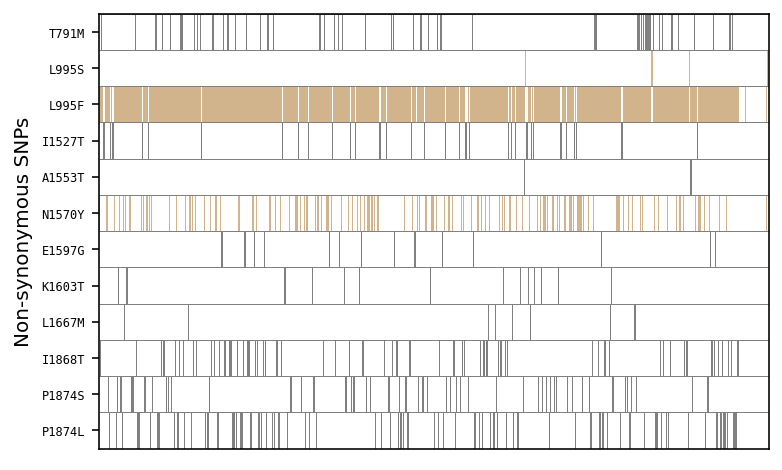

In [ ]:
fig, ax = plt.subplots()
plot_missense_haplotypes(ax, h_missense, missense_mutations)

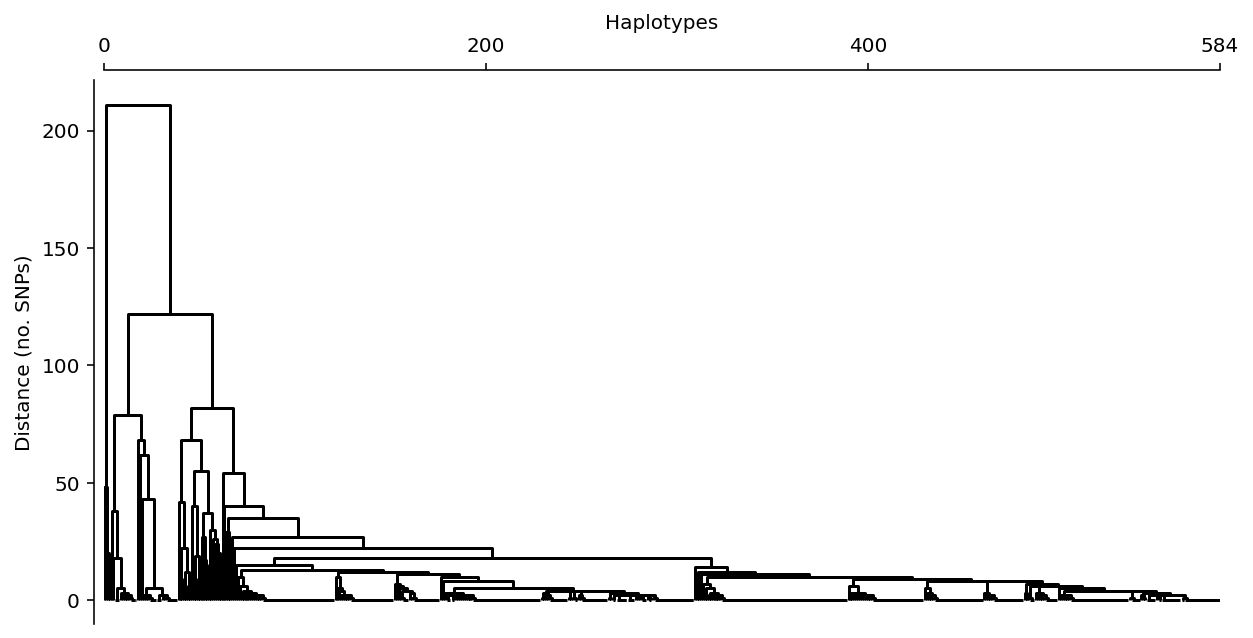

In [ ]:
def plot_dendrogram(h, ax, method='complete', color_threshold=0, above_threshold_color='k'):
    
    # compute distance matrix
    dist = allel.pairwise_distance(h, 'hamming') * h.shape[0]

    # HACKING SCIPY TO GET TO OLD CLUSTERING METHOD
    # https://github.com/scipy/scipy/blob/v0.18.1/scipy/cluster/hierarchy.py#L470-L667
    # 1. fiddle with format
    y = _convert_to_double(np.asarray(dist, order='c'))
    # 2. get n
    n = int(distance.num_obs_y(dist))
    # 3. do clustering
    method = dict(single=0, complete=1)[method]
    z = _hierarchy.linkage(y, n, method)    

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(z, no_labels=True, count_sort=True, 
                                           color_threshold=color_threshold, 
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-10)
#     ax.set_xlim(left=-10)
    ax.set_ylabel('Distance (no. SNPs)')
    ax.autoscale(axis='x', tight=True)
    return z, r

fig, ax = plt.subplots(figsize=(10, 5))
plot_dendrogram(h, ax);

In [ ]:
#assert len(meta) == h.shape[1]

In [ ]:
def fig_hap_structure(h, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(10, 8), 
                      fn=None, dpi=150, height_ratios=(2.5, .2, 2.8, .2), hap_pops=None, legend=True):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 4
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r = plot_dendrogram(h, ax_dend, color_threshold=0)
    ax_dend.set_ylim(bottom=-5)
#     for xmin, xmax in vspans:
#         ax.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), 1,
#                                    facecolor='k', edgecolor='k', alpha=.1,
#                                    transform=ax.transAxes, zorder=20))
#     ax.vlines(vspans.flat, 0, 1, transform=ax.transAxes, linestyle=':')

    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = hap_meta.population.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_colours[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Populations', rotation=0, ha='right', va='center')

    # missense mutations
    if h_display is not None:
        ax_mut = fig.add_subplot(gs[2, 0])
        plot_missense_haplotypes(ax_mut, h_display.take(r['leaves'], axis=1), mutations)
        ax_mut.set_xticks([])
        ax_mut.yaxis.set_tick_params(length=3, pad=2)

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -20 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
            ax_pops.vlines([xmin, xmax], 0, 1, linestyle='--')
            ax_mut.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), h_display.shape[0],
                             facecolor='gray', edgecolor='gray', alpha=.1,
                             zorder=20))
            ax_mut.vlines([xmin, xmax], 0, h_display.shape[0], linestyle='--', lw=1)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')

    if legend:
      handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop) for pop in meta.population.unique()]
      ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.35, 0.15), ncol=1)


    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
        
    return z, r

<ipython-input-113-9e197e886529>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


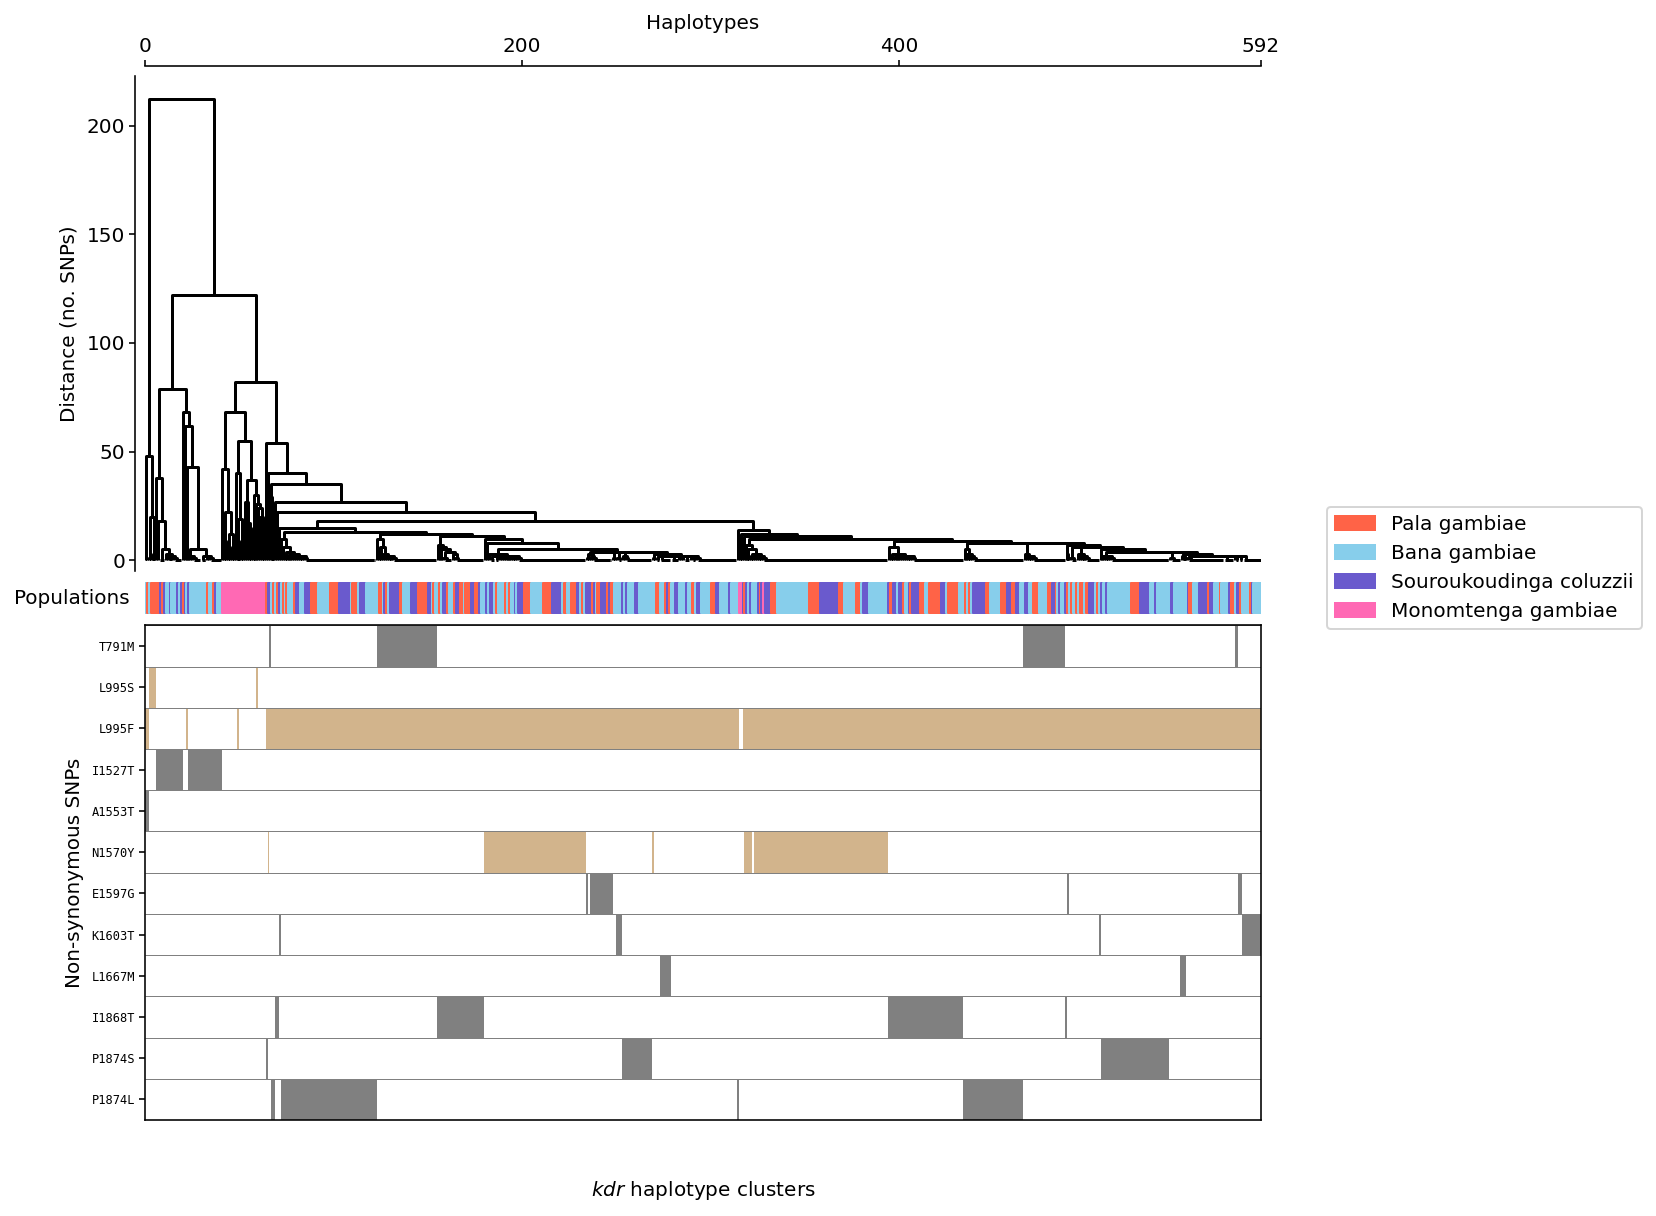

In [ ]:
z, r = fig_hap_structure(h, h_missense, missense_mutations, legend=True,figsize=(10, 10), height_ratios=(3, .2, 3, .2))

In [ ]:
# gives the haplotype indices of the haplotypes in the n largest clusters
def find_clusters(z, n, threshold=12):
    
    # find clusters
    f = scipy.cluster.hierarchy.fcluster(z, threshold, criterion='distance')
    
    # compute cluster sizes
    fsz = np.bincount(f)
    
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    
    # take largest n
    fsort = fsort[:n]
    
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    
    return clusters

In [ ]:
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

In [ ]:
clustard = find_clusters(z, n=10, threshold=10)
clustard

<ipython-input-120-4b68d836d3a8>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


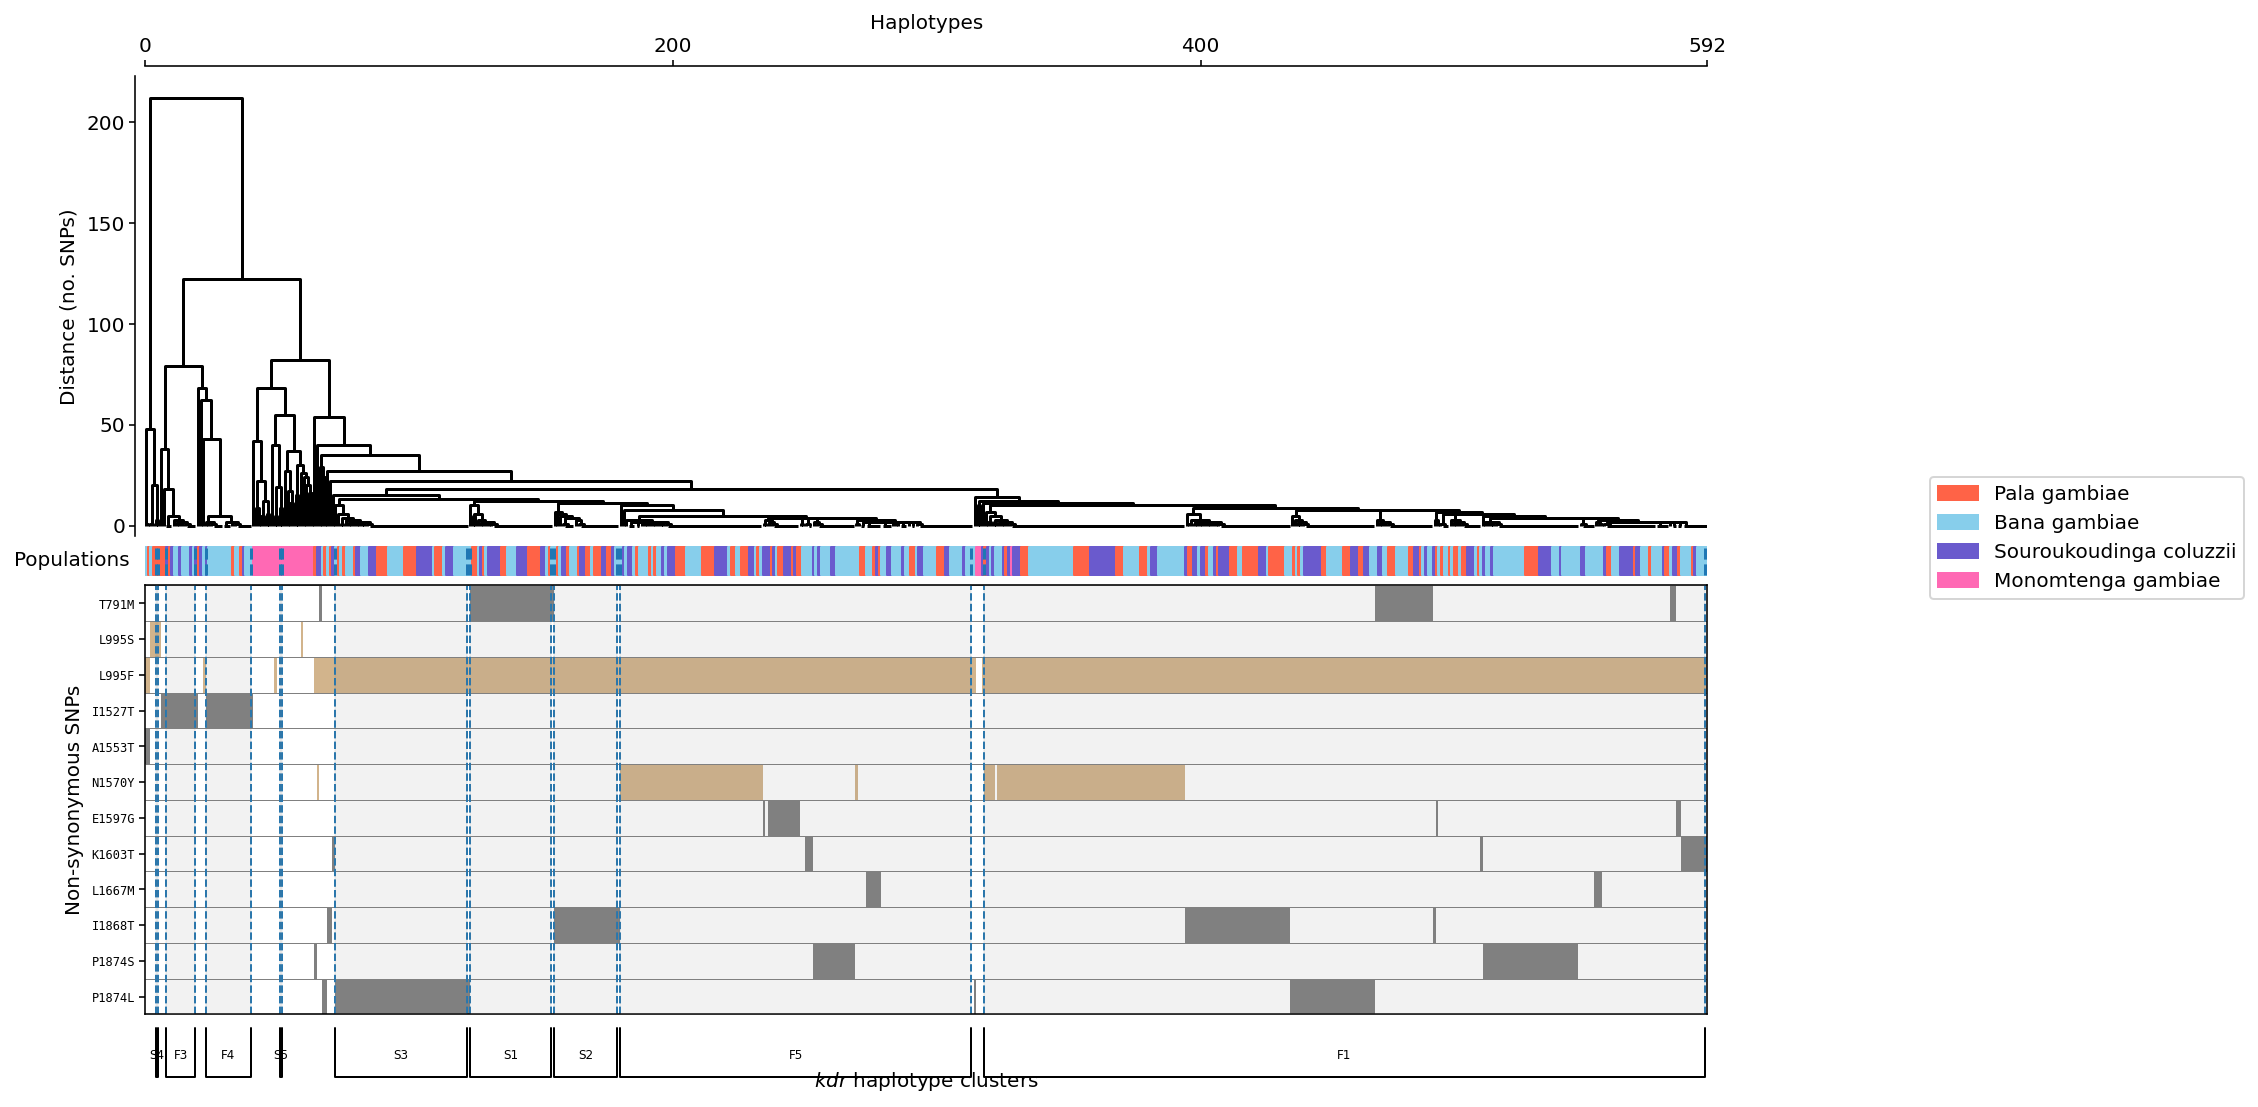

In [ ]:
clustard = find_clusters(z, n=10, threshold=10)
vspans = [truspan(cluster, r) for cluster in clustard]
cluster_labels = ['F1', 'F5', 'S3', 'S1', 'S2', 'F4', 'F3', 'S4', 'S5', '', '', '', '', '', 'F2']
fig_hap_structure(h, h_missense, mutations=missense_mutations, vspans=np.array(vspans), cluster_labels=cluster_labels, 
                  figsize=(14, 9), height_ratios=(3, .2, 2.8, .2));
fig = plt.gcf()
ax_dend = fig.axes[0]